# Coursera Capstone: Foursquare Density Analysis
by Ryan Ruff

## Background
When I first connected to the Foursquare API, I did a test search around my current location (Portsmouth, VA) and had a dismal selection of venues to look at.  

As my capstone project, I thought it might be interesting to see if I could use the Foursquare API to locate other Virginia cities with low Foursquare "venue density". 

I'm curious to found out what characteristics these cities share in common.  I think this information might be valuable to providers of APIs like Foursquare, because
it would allow them to enact targeted plans to engage excluded communities and increase coverage of their app.

## Data Sources

* List of Virginia Cities from Wikipedia
* Geolocation data scraped from Geonames.org 
* Foursquare API

My tentative plan is to use the list of VA Zip codes to find an initial list of coordinates, then use the Foursquare API to sample the density of venues around that location.

## Methodology

The following code documents the process I used to complete my analysis.

In [1]:
# Start by importing the libraries I'll need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
#Install folium as needed 
!pip install folium
import folium

from urllib.parse import quote

     |████████████████████████████████| 92kB 5.4MB/s eta 0:00:011


In [2]:
# Webscrape Wikipedia for a list of VA cities
wikicities = requests.get('https://en.wikipedia.org/wiki/List_of_cities_and_counties_in_Virginia')

In [3]:
# Use BeautifulSoup to clean it up
wikisoup = BeautifulSoup(wikicities.text,'html.parser')


In [4]:
tables = wikisoup.find_all("table")
rows = tables[3].find_all('tr')
def cell_cleaner(c):
    return c.get_text().strip()
headers = list(map(cell_cleaner,rows[0].find_all('th')))

df_dict = dict()
for h in headers:
    df_dict[h]=[]
for r in rows[1:]:
    tds = r.find_all('td')
    for i in range(len(headers)):
        if (i == 0):
            df_dict[headers[i]].append(r.th.get_text().strip())
        elif (i < len(tds)):
            df_dict[headers[i]].append(cell_cleaner(tds[i-1]))
        else:
            df_dict[headers[i]].append('')

df_wiki = pd.DataFrame(df_dict)
df_wiki.head()

,City,FIPS code[4],Seat[5],Est.[5],Origin,Etymology,Population[5],Area[5],Map
0,Alexandria,510,N/A,1902[10],From Alexandria County before 1870[11],"Phillip & John Alexander, brothers and area pl...","147,391",15 sq mi(39 km2),
1,Bristol,520,N/A,1902[10],From Washington County in 1890[11],"Bristol, England","17,367",12 sq mi(31 km2),
2,Buena Vista,530,N/A,1902[10],From Rockbridge County in 1892[11],"from the Buena Vista Company, which founded an...","6,349",7 sq mi(18 km2),
3,Charlottesville,540,N/A,1902[10],From Albemarle County in 1888[11],"Charlotte of Mecklenburg-Strelitz, wife of Kin...","45,049",10 sq mi(26 km2),
4,Chesapeake,550,N/A,1963,Formed out of consolidation of Norfolk County ...,Chesapeake tribe,"222,209",341 sq mi(883 km2),


In [5]:
df_wiki['City']

0           Alexandria
1              Bristol
2          Buena Vista
3      Charlottesville
4           Chesapeake
5     Colonial Heights
6            Covington
7             Danville
8              Emporia
9              Fairfax
10        Falls Church
11            Franklin
12      Fredericksburg
13               Galax
14             Hampton
15        Harrisonburg
16            Hopewell
17           Lexington
18           Lynchburg
19            Manassas
20       Manassas Park
21        Martinsville
22        Newport News
23             Norfolk
24              Norton
25          Petersburg
26            Poquoson
27          Portsmouth
28             Radford
29            Richmond
30             Roanoke
31               Salem
32            Staunton
33             Suffolk
34      Virginia Beach
35          Waynesboro
36        Williamsburg
37          Winchester
Name: City, dtype: object

In [6]:
quote(df_wiki['City'][0]+' Virginia')

'Alexandria%20Virginia'

In [7]:
# Webscrape VA zip codes from Geonames.org
def webscrape_zip_codes(city):
    query = city+" Virginia"
    geonames = requests.get('http://www.geonames.org/postalcode-search.html?q='+query+'&country=US')
    geosoup = BeautifulSoup(geonames.text,'html.parser')
    tablesoup = geosoup.find('table',attrs={'class':"restable"})
    rows = tablesoup.find_all('tr')
    num_rows = len(rows)


    headers = list(map(cell_cleaner,rows[0].find_all('th')))
    num_cols = len(headers)
    df_dict = {'Loc':[]}

    for h in headers:
        df_dict[h]=[]

    
    for r in range(int(num_rows/2)-1):
        tds = rows[2*r+1].find_all('td')
        for i in range(num_cols):
            df_dict[headers[i]].append(cell_cleaner(tds[i]))
        df_dict['Loc'].append(rows[2*r+2].find('small').get_text()) 
    df = pd.DataFrame(df_dict)
    return df


In [8]:
# scrap all the zip codes for each city
city_dfs = []
for city in df_wiki['City']:
    city_dfs.append(webscrape_zip_codes(city))

In [9]:
df_zipcodes = pd.concat(city_dfs)
df_zipcodes.shape

(414, 8)

In [10]:
df_zipcodes.columns = ['Loc', 'Num', 'City', 'Code', 'Country', 'State', 'County', 'Admin3']
df_zipcodes = df_zipcodes[['Loc', 'City', 'Code', 'State', 'County']]
df_zipcodes.head()

,Loc,City,Code,State,County
0,38.791/-77.081,Alexandria,22303,Virginia,Fairfax
1,38.759/-77.087,Alexandria,22306,Virginia,Fairfax
2,38.779/-77.119,Alexandria,22310,Virginia,Fairfax
3,38.819/-77.148,Alexandria,22312,Virginia,Fairfax
4,38.771/-77.066,Alexandria,22307,Virginia,Fairfax


In [11]:
lats = []
longs = []
for loc in df_zipcodes["Loc"]:
    strs = str(loc).split('/')
    lats.append(float(strs[0]))
    longs.append(float(strs[1]))
df_zipcodes['Latitude'] = lats
df_zipcodes['Longitude'] = longs
df_zipcodes.head()

,Loc,City,Code,State,County,Latitude,Longitude
0,38.791/-77.081,Alexandria,22303,Virginia,Fairfax,38.791,-77.081
1,38.759/-77.087,Alexandria,22306,Virginia,Fairfax,38.759,-77.087
2,38.779/-77.119,Alexandria,22310,Virginia,Fairfax,38.779,-77.119
3,38.819/-77.148,Alexandria,22312,Virginia,Fairfax,38.819,-77.148
4,38.771/-77.066,Alexandria,22307,Virginia,Fairfax,38.771,-77.066


In [12]:
df_zipcodes = df_zipcodes[df_zipcodes['State']=='Virginia']

In [13]:
df_cities = df_zipcodes.groupby('City').mean().reset_index()

In [14]:
print(df_cities.shape)
df_cities.head()

(87, 3)


,City,Latitude,Longitude
0,Alexandria,38.788207,-77.091483
1,Annandale,38.831000,-77.214000
2,Bent Mountain,37.155000,-80.122000
3,Boones Mill,37.133000,-79.956000
4,Bristol,36.613200,-82.190600


In [15]:
mean_lat = df_cities['Latitude'].mean()
mean_lng = df_cities['Longitude'].mean()

map_VA = folium.Map(location=[mean_lat,mean_lng],zoom_start=8)
for lat, lng, city in zip(df_cities['Latitude'], df_cities['Longitude'], df_cities['City']):
    label = folium.Popup(city, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_VA) 
map_VA

In [16]:
# next let's load up the Foursquare API
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
VERSION = '20200311'

In [17]:
# hidden cell test
CLIENT_ID = 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz'
CLIENT_SECRET = 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzz'

In [18]:
def getNearbyVenues(name, lat, lng, radius=500, limit=100):    
         
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        limit)
        
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    return [(name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['id'] 
            ) for v in results]

In [19]:
avg_venues = []
venues = []
for city in df_cities["City"]:
    num_venues = []
    df_zips = df_zipcodes[df_zipcodes["City"]==city]
    for zipcode,lat,lng in zip(df_zips["Code"],df_zips["Latitude"],df_zips["Longitude"]):
        vens = getNearbyVenues(zipcode,lat,lng)
        venues.append(vens)
        num_venues.append(len(vens))
    avg_venues.append(np.mean(num_venues))

df_cities["Avg Num Venues"] = avg_venues
df_cities.head()

,City,Latitude,Longitude,Avg Num Venues
0,Alexandria,38.788207,-77.091483,20.0
1,Annandale,38.831000,-77.214000,6.0
2,Bent Mountain,37.155000,-80.122000,0.0
3,Boones Mill,37.133000,-79.956000,0.0
4,Bristol,36.613200,-82.190600,13.4


In [20]:
df_cities.sort_values(by="Avg Num Venues",inplace=True)
df_cities.head()

,City,Latitude,Longitude,Avg Num Venues
86,Wirtz,37.082,-79.757,0.0
80,Warsaw,37.970,-76.767,0.0
31,Franklin,36.679,-76.939,0.0
33,Galax,36.657,-80.912,0.0
34,Glade Hill,36.986,-79.773,0.0


In [21]:
df_cities.tail()

,City,Latitude,Longitude,Avg Num Venues
55,Norfolk,36.896810,-76.258476,17.190476
0,Alexandria,38.788207,-77.091483,20.000000
38,Harrisonburg,38.457750,-78.858000,21.500000
50,Mc Lean,38.936333,-77.188000,29.000000
51,Merrifield,38.856600,-77.254600,32.800000


It looks like a substantial number of Virginia Cities returned no venues.  The city with the most was Merrifield, which had approximately 31 venues per zipcode.

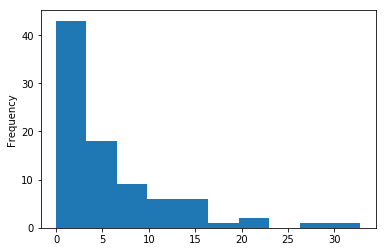

In [22]:
df_cities["Avg Num Venues"].plot(kind='hist')

In [23]:
df_cities[df_cities["City"]=="Portsmouth"]

,City,Latitude,Longitude,Avg Num Venues
61,Portsmouth,36.84025,-76.3435,9.125


In [24]:
df_cities["Avg Num Venues"].describe()

count    87.000000
mean      5.431406
std       6.534875
min       0.000000
25%       0.937500
50%       3.750000
75%       8.119048
max      32.800000
Name: Avg Num Venues, dtype: float64

In [25]:
Q1 = df_cities["Avg Num Venues"].quantile(.25)
Q2 = df_cities["Avg Num Venues"].quantile(.5)
Q3 = df_cities["Avg Num Venues"].quantile(.75)
def get_quartile(x):
    if (x < Q1):
        return 0
    elif (x < Q2):
        return 1
    elif (x < Q3):
        return 2
    else:
        return 3
df_cities["Quartile"] = df_cities["Avg Num Venues"].map(get_quartile)
df_cities.tail()

,City,Latitude,Longitude,Avg Num Venues,Quartile
55,Norfolk,36.896810,-76.258476,17.190476,3
0,Alexandria,38.788207,-77.091483,20.000000,3
38,Harrisonburg,38.457750,-78.858000,21.500000,3
50,Mc Lean,38.936333,-77.188000,29.000000,3
51,Merrifield,38.856600,-77.254600,32.800000,3


In [26]:
# Let's map again, but color coded by quartile
colors = ['red','orange','yellow','green']
map_VA = folium.Map(location=[mean_lat,mean_lng],zoom_start=8)
for lat, lng, city,q in zip(df_cities['Latitude'], df_cities['Longitude'], df_cities['City'], df_cities['Quartile']):
    label = folium.Popup(city, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[q],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_VA) 
map_VA

Visually, we can see that the cities with the highest Foursquare usage are near major urban centers.  A few outliers appear to be located near national parks.

In [27]:
# okay, lets go back to the list of venues we saved earlier and map it into a dataframe
df_venues = pd.DataFrame([item for venues in venues for item in venues])
df_venues.columns = ['Zipcode', 
                  'Zip Latitude', 
                  'Zip Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue ID']
df_venues.head()

,Zipcode,Zip Latitude,Zip Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
0,22303,38.791,-77.081,Balkan Grill,38.789990,-77.076875,Eastern European Restaurant,4c18032cfe5a76b0e36e0115
1,22303,38.791,-77.081,Voila Pastry and Cafe,38.789836,-77.077063,Bakery,51e3007c498e637126ddb16f
2,22303,38.791,-77.081,Bob and Edith's Diner,38.789388,-77.076864,Diner,597fde2a237dee2ae929aa26
3,22303,38.791,-77.081,7-Eleven,38.790861,-77.077287,Convenience Store,4bce462cc564ef3b9b0feef0
4,22303,38.791,-77.081,Abi 2 Restaurant,38.790222,-77.077006,Mexican Restaurant,4c098e77bbc676b0267048d5


In [28]:
df_venues.shape

(3795, 8)

In [29]:
df_venues.groupby("Venue ID").Zipcode.nunique()

Venue ID
40b13b00f964a5201af41ee3    1
40b13b00f964a52060f41ee3    1
40b13b00f964a52060f71ee3    1
40b13b00f964a52094f41ee3    1
40b13b00f964a520def41ee3    1
41083e00f964a520940b1fe3    3
41366280f964a520c51a1fe3    2
42893400f964a52069231fe3    2
428a8580f964a52093231fe3    2
468e12d5f964a52078481fe3    4
468e133bf964a52079481fe3    2
4a32578ef964a5203f9a1fe3    1
4a3c2915f964a52034a11fe3    2
4a46c183f964a52066a91fe3    1
4a477f40f964a520cba91fe3    1
4a4a11dbf964a52088ab1fe3    3
4a636a87f964a520fac41fe3    3
4a66366af964a52039c81fe3    1
4a67c4d1f964a52006ca1fe3    1
4a6bb115f964a520a2cf1fe3    2
4a6ddc85f964a5202ad31fe3    1
4a750c9ff964a52063e01fe3    4
4a7523e0f964a520a3e01fe3    2
4a775854f964a52036e41fe3    1
4a81ae2ff964a5203ef71fe3    3
4a84b994f964a52072fd1fe3    4
4a882342f964a520410520e3    1
4a8b2c1cf964a520a50b20e3    2
4a8b4287f964a520f30b20e3    1
4a904669f964a520fb1620e3    2
                           ..
5ca3e70d971317002d67a00d    1
5cbcfd79ccad6b002c09220d    2
5

Since I searched for venues by zip code, some of the same venues show up in multiple overlapping searches.

Before I cluser them, lets clean it up remove the duplicates.

In [35]:
def get_zip_quadrance(d):
    return (d["Zip Latitude"]-d["Venue Latitude"])**2+(d["Zip Longitude"]-d["Venue Longitude"])**2

df_venues["Zip Quadrance"] = get_zip_quadrance(df_venues)
df_venues.head()

,Zipcode,Zip Latitude,Zip Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID,Zip Quadrance
0,22303,38.791,-77.081,Balkan Grill,38.789990,-77.076875,Eastern European Restaurant,4c18032cfe5a76b0e36e0115,0.000018
1,22303,38.791,-77.081,Voila Pastry and Cafe,38.789836,-77.077063,Bakery,51e3007c498e637126ddb16f,0.000017
2,22303,38.791,-77.081,Bob and Edith's Diner,38.789388,-77.076864,Diner,597fde2a237dee2ae929aa26,0.000020
3,22303,38.791,-77.081,7-Eleven,38.790861,-77.077287,Convenience Store,4bce462cc564ef3b9b0feef0,0.000014
4,22303,38.791,-77.081,Abi 2 Restaurant,38.790222,-77.077006,Mexican Restaurant,4c098e77bbc676b0267048d5,0.000017


In [46]:
grouped = df_venues.groupby("Venue ID")
min_quadrance = grouped["Zip Quadrance"].aggregate(np.min)


In [59]:
min_quad_dict = min_quadrance.to_dict()
df_venues["Min Quadrance"] = df_venues["Venue ID"].map(min_quad_dict)
df_venues.head()

,Zipcode,Zip Latitude,Zip Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID,Zip Quadrance,Min Quadrance
0,22303,38.791,-77.081,Balkan Grill,38.789990,-77.076875,Eastern European Restaurant,4c18032cfe5a76b0e36e0115,0.000018,0.000018
1,22303,38.791,-77.081,Voila Pastry and Cafe,38.789836,-77.077063,Bakery,51e3007c498e637126ddb16f,0.000017,0.000017
2,22303,38.791,-77.081,Bob and Edith's Diner,38.789388,-77.076864,Diner,597fde2a237dee2ae929aa26,0.000020,0.000020
3,22303,38.791,-77.081,7-Eleven,38.790861,-77.077287,Convenience Store,4bce462cc564ef3b9b0feef0,0.000014,0.000014
4,22303,38.791,-77.081,Abi 2 Restaurant,38.790222,-77.077006,Mexican Restaurant,4c098e77bbc676b0267048d5,0.000017,0.000017


In [61]:
df_venues_clean = df_venues[df_venues["Zip Quadrance"]==df_venues["Min Quadrance"]]


In [62]:
print(df_venues.shape)
print(df_venues_clean.shape)

(3795, 10)
(3132, 10)


In [65]:
df_venues_clean.groupby("Venue ID").Zipcode.nunique()

Venue ID
40b13b00f964a5201af41ee3    1
40b13b00f964a52060f41ee3    1
40b13b00f964a52060f71ee3    1
40b13b00f964a52094f41ee3    1
40b13b00f964a520def41ee3    1
41083e00f964a520940b1fe3    1
41366280f964a520c51a1fe3    1
42893400f964a52069231fe3    2
428a8580f964a52093231fe3    1
468e12d5f964a52078481fe3    2
468e133bf964a52079481fe3    1
4a32578ef964a5203f9a1fe3    1
4a3c2915f964a52034a11fe3    2
4a46c183f964a52066a91fe3    1
4a477f40f964a520cba91fe3    1
4a4a11dbf964a52088ab1fe3    1
4a636a87f964a520fac41fe3    1
4a66366af964a52039c81fe3    1
4a67c4d1f964a52006ca1fe3    1
4a6bb115f964a520a2cf1fe3    1
4a6ddc85f964a5202ad31fe3    1
4a750c9ff964a52063e01fe3    1
4a7523e0f964a520a3e01fe3    1
4a775854f964a52036e41fe3    1
4a81ae2ff964a5203ef71fe3    1
4a84b994f964a52072fd1fe3    2
4a882342f964a520410520e3    1
4a8b2c1cf964a520a50b20e3    2
4a8b4287f964a520f30b20e3    1
4a904669f964a520fb1620e3    1
                           ..
5ca3e70d971317002d67a00d    1
5cbcfd79ccad6b002c09220d    1
5

In [67]:
# better, but still some duplicates
df_venues_clean[df_venues_clean["Venue ID"]=="5e2f178cb5a4830007be102d"]

,Zipcode,Zip Latitude,Zip Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID,Zip Quadrance,Min Quadrance
2693,23260,37.554,-77.46,Whole Foods Market,37.558196,-77.461217,Grocery Store,5e2f178cb5a4830007be102d,0.000019,0.000019
2722,23261,37.554,-77.46,Whole Foods Market,37.558196,-77.461217,Grocery Store,5e2f178cb5a4830007be102d,0.000019,0.000019
2751,23269,37.554,-77.46,Whole Foods Market,37.558196,-77.461217,Grocery Store,5e2f178cb5a4830007be102d,0.000019,0.000019
2942,23282,37.554,-77.46,Whole Foods Market,37.558196,-77.461217,Grocery Store,5e2f178cb5a4830007be102d,0.000019,0.000019
3011,23173,37.554,-77.46,Whole Foods Market,37.558196,-77.461217,Grocery Store,5e2f178cb5a4830007be102d,0.000019,0.000019


In [78]:
# ugh, some of my zip codes have the exact same lat/long values
# lets use the city name instead then
df_venues_clean = df_venues_clean.join(df_zipcodes[["City","Code"]].set_index("Code"),on="Zipcode")
df_venues_clean.head()

,Zipcode,Zip Latitude,Zip Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID,Zip Quadrance,Min Quadrance,City
0,22303,38.791,-77.081,Balkan Grill,38.789990,-77.076875,Eastern European Restaurant,4c18032cfe5a76b0e36e0115,0.000018,0.000018,Alexandria
0,22303,38.791,-77.081,Balkan Grill,38.789990,-77.076875,Eastern European Restaurant,4c18032cfe5a76b0e36e0115,0.000018,0.000018,Alexandria
1,22303,38.791,-77.081,Voila Pastry and Cafe,38.789836,-77.077063,Bakery,51e3007c498e637126ddb16f,0.000017,0.000017,Alexandria
1,22303,38.791,-77.081,Voila Pastry and Cafe,38.789836,-77.077063,Bakery,51e3007c498e637126ddb16f,0.000017,0.000017,Alexandria
2,22303,38.791,-77.081,Bob and Edith's Diner,38.789388,-77.076864,Diner,597fde2a237dee2ae929aa26,0.000020,0.000020,Alexandria


In [243]:
va_onehot = pd.get_dummies(df_venues_clean[['Venue Category']],prefix="",prefix_sep="")
va_onehot['City'] = df_venues_clean['City']
va_onehot.head()

,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Video Store,Vietnamese Restaurant,Waterfall,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,City
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Alexandria
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Alexandria
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Alexandria
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Alexandria
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Alexandria


In [244]:
va_onehot.shape

(3484, 302)

In [245]:
va_grouped = va_onehot.groupby('City').mean().reset_index()
va_grouped

,City,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,...,Video Game Store,Video Store,Vietnamese Restaurant,Waterfall,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Alexandria,0.000000,0.000000,0.000000,0.00738,0.001845,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.001845,0.0,0.000000,0.003690,0.001845,0.003690,0.001845,0.020295
1,Annandale,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Bristol,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000
3,Buena Vista,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Burke,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Centreville,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Chantilly,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Charlottesville,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.007246,0.007246,0.000000,0.000000
8,Chesapeake,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000
9,Chester Gap,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [246]:
from sklearn.cluster import KMeans

In [247]:
# set number of clusters
kclusters = 4

va_grouped_clustering = va_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(va_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 0], dtype=int32)

In [248]:
len(kmeans.labels_)

67

In [249]:
va_grouped['Cluster'] = kmeans.labels_

In [250]:
va_grouped.head()

,City,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,...,Video Store,Vietnamese Restaurant,Waterfall,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Cluster
0,Alexandria,0.0,0.0,0.0,0.00738,0.001845,0.0,0.0,0.0,0.0,...,0.0,0.001845,0.0,0.0,0.00369,0.001845,0.003690,0.001845,0.020295,3
1,Annandale,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,3
2,Bristol,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.027778,0.000000,0.000000,3
3,Buena Vista,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,3
4,Burke,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,3


In [251]:
print(df_cities.shape)
print(va_grouped.shape)

(87, 5)
(67, 303)


In [252]:
va_merged = pd.merge(df_cities,va_grouped[["City","Cluster"]],left_on='City',right_on='City',how="outer")
va_merged.head()

,City,Latitude,Longitude,Avg Num Venues,Quartile,Cluster
0,Wirtz,37.082,-79.757,0.0,0,NaN
1,Warsaw,37.970,-76.767,0.0,0,NaN
2,Franklin,36.679,-76.939,0.0,0,NaN
3,Galax,36.657,-80.912,0.0,0,NaN
4,Glade Hill,36.986,-79.773,0.0,0,NaN


In [253]:
va_merged["Cluster"] = va_merged["Cluster"].fillna(kclusters)

In [254]:
cities_by_cluster = va_merged.groupby("Cluster").City.unique()

In [255]:
cities_by_cluster

Cluster
0.0                                [Chester Gap, Ferrum]
1.0    [Penhook, Greenway, Great Falls, West Mclean, ...
2.0                                        [Fort Monroe]
3.0    [Marshall, Suffolk, Emporia, Elliston, Colonia...
4.0    [Wirtz, Warsaw, Franklin, Galax, Glade Hill, H...
Name: City, dtype: object

In [256]:
# let's visualize the output
import matplotlib.cm as cm
import matplotlib.colors as colors

x = np.arange(kclusters+1)
ys = [i + x + (i*x)**2 for i in range(kclusters+1)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [257]:
rainbow

['#8000ff', '#00b5eb', '#80ffb4', '#ffb360', '#ff0000']

In [259]:
map_VA = folium.Map(location=[mean_lat,mean_lng],zoom_start=8)
for lat, lng, city,q in zip(va_merged['Latitude'], va_merged['Longitude'], va_merged['City'], va_merged['Cluster']):
    label = folium.Popup(city, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[int(q)],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_VA) 
map_VA

This provided a very similar output to the density only map.  Let's dig in a little deeper and find some more patterns.

In [260]:
kmeans.cluster_centers_

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.001243  , 0.00020421, 0.00014364, ..., 0.00080933, 0.00170429,
        0.00102065]])

In [261]:
va_grouped.columns[1:]

Index(['ATM', 'Accessories Store', 'Adult Boutique', 'Afghan Restaurant',
       'African Restaurant', 'Airport', 'Airport Lounge', 'Airport Service',
       'Airport Terminal', 'American Restaurant',
       ...
       'Video Store', 'Vietnamese Restaurant', 'Waterfall',
       'Weight Loss Center', 'Wine Bar', 'Wine Shop', 'Wings Joint',
       'Women's Store', 'Yoga Studio', 'Cluster'],
      dtype='object', length=302)

In [262]:
print(len(kmeans.cluster_centers_[0]))
print(len(va_grouped.columns[1:]))

301
302


In [263]:
def print_cluster_summary(k):
    print("Cluster #: "+str(k))
    print("Cities: "+str(cities_by_cluster[k]))
    highs = []
    lows = []
    if (k == kclusters):
        print("This cluster has no Foursquare venues at all.")
        return
    for i in range(len(kmeans.cluster_centers_[k])):
        if (kmeans.cluster_centers_[k][i]>np.finfo(float).eps):
            highs.append(va_grouped.columns[i+1])
        elif (kmeans.cluster_centers_[k][i]<-np.finfo(float).eps):
            lows.append(va_grouped.columns[i+1])
    print("This cluster scored high in "+str(highs))
    print("This cluster scored low in "+str(lows))


In [264]:
for j in range(kclusters+1):
    print_cluster_summary(j)
    print("--------------------------")

Cluster #: 0
Cities: ['Chester Gap' 'Ferrum']
This cluster scored high in ['Sandwich Place', 'Trail']
This cluster scored low in []
--------------------------
Cluster #: 1
Cities: ['Penhook' 'Greenway' 'Great Falls' 'West Mclean' 'Culpeper']
This cluster scored high in ['Garden Center', 'Home Service', 'Park']
This cluster scored low in []
--------------------------
Cluster #: 2
Cities: ['Fort Monroe']
This cluster scored high in ['Beach']
This cluster scored low in []
--------------------------
Cluster #: 3
Cities: ['Marshall' 'Suffolk' 'Emporia' 'Elliston' 'Colonial Beach'
 'Colonial Heights' 'Martinsville' 'Vienna' 'Burke' 'Centreville'
 'Hampton' 'Danville' 'Newport News' 'Virginia State University'
 'Rocky Mount' 'Williamsburg' 'Reston' 'Poquoson' 'Mount Vernon' 'Vinton'
 'Lorton' 'Lexington' 'Dunn Loring' 'Radford' 'Fairfax' 'Salem'
 'Waynesboro' 'Norton' 'Buena Vista' 'Lynchburg' 'Staunton' 'Chesapeake'
 'Annandale' 'Henrico' 'Winchester' 'Manassas' 'Fairfax Station'
 'Virginia 